<a href="https://colab.research.google.com/github/HayeonKimm/project/blob/master/Project/Machine-Learning/My_Project/ETA_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make the best model for TADA ETA

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# scikit-learn 최신 버전으로 업그레이드
!pip install -U scikit-learn
import sklearn
print("scikit-learn version: ", sklearn.__version__)

scikit-learn version:  1.0.1


### Regression Tree with Tada ETA data



*   ATA: Actual Time of Arrival
*   ETA: Expected Time of Arrival
*   api_eta: 앱 API에서 예측된 ETA



In [ ]:
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
print(tada_eta.columns)
tada_eta.head()

Index(['ATA', 'id', 'api_eta', 'created_at_kst', 'month', 'pickup_lng',
       'pickup_lat', 'pickup_gu', 'driver_id', 'driver_lng', 'driver_lat',
       'hour'],
      dtype='object')


,ATA,id,api_eta,created_at_kst,month,pickup_lng,pickup_lat,pickup_gu,driver_id,driver_lng,driver_lat,hour
0,10.60,R4L9FL6NVEL4D0,5.65,2019-12-01T00:55:09,12,127.091399,37.624545,노원구,DST52944,127.069978,37.616472,0
1,9.20,R3A7JBY7CS6TPD,8.60,2019-12-01T00:09:39,12,127.023351,37.625564,강북구,DPC72995,127.026479,37.604711,0
2,10.85,R2BIUY1TDK14XE,10.53,2019-12-15T00:18:42,12,126.881154,37.481641,금천구,DPP94923,126.906225,37.452167,0
3,5.52,R31PU5GNHSGU6C,1.92,2019-07-31T00:24:11,7,126.988375,37.567897,중구,DCT73585,126.991170,37.566416,0
4,8.60,R41WR6N1VT42DJ,7.10,2019-07-05T00:40:34,7,126.988684,37.566716,중구,DPJ86237,127.006860,37.571164,0


In [ ]:
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat','pickup_gu'],1)
tada_eta.head()

# sklearn의 tree는 범주 데이터는 다루지 못함. 이 경우에 one-hot encoding은 비효율적. 구 데이터도 활용하고 싶다면 h2o 참고

,ATA,api_eta,month,hour,distance
0,10.60,5.65,12,0,52.400202
1,9.20,8.60,12,0,44.465889
2,10.85,10.53,12,0,149.731535
3,5.52,1.92,7,0,1.000535
4,8.60,7.10,7,0,35.014797


## 샘플링

In [ ]:
tada_eta = tada_eta.sample(frac=1, random_state=0).reset_index(drop=True)
tada_eta.head()

,ATA,api_eta,month,hour,distance
0,6.13,8.32,12,22,44.521977
1,5.37,3.05,12,11,3.989066
2,6.27,5.00,7,19,4.814699
3,10.52,8.47,12,21,77.341173
4,12.45,6.65,7,12,14.888851


In [ ]:
tada_eta.shape

(13916, 5)

In [ ]:
train = tada_eta[:12000]
test = tada_eta[12000:]

In [ ]:
x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]

# PCA

## x_train과 x_test 를 PCA한다.

In [ ]:
train = tada_eta[:12000]
test = tada_eta[12000:]


x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]


# Principal Components Analysis (PCA)
# Using PCA to find the first two principal components of the breast cancer dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
# PCA를 하기전에는 정규화를 해야한다. 그렇지 않으면 성능이 좋지 않을 수 있다..!

X_normalized = StandardScaler().fit(x_train).transform(x_train)  
pca = PCA(n_components = 2).fit(X_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
X_pca = pca.transform(X_normalized) # transform은 해줘야 한다.

# print(train.shape, X_pca.shape)


x_normalized = StandardScaler().fit(x_test).transform(x_test)  
pca = PCA(n_components = 2).fit(x_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
x_pca = pca.transform(x_normalized) # transform은 해줘야 한다.

print(x_train.shape, X_pca.shape,x_test.shape,x_pca.shape)

(12000, 4) (12000, 2) (1916, 4) (1916, 2)


In [ ]:
type(X_pca)

numpy.ndarray

In [ ]:
eta_features

['api_eta', 'month', 'hour', 'distance']

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error # 절대값
from sklearn import ensemble

# 1 way + gridsearchCV

In [ ]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
# Hyperparameter 조합 정의
param_grid = {'n_estimators': [100, 200, 300],
  'max_depth': [2, 3, 4, 5],
   'min_samples_leaf': [1, 20, 100],
  'learning_rate': [0.01, 0.02, 0.05],
  'loss': ['ls']} 
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                   param_grid=param_grid, 
                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_pca, y_train)
print(grid_search.best_params_)
reg = ensemble.GradientBoostingRegressor(**grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


{'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 200}


In [ ]:
params = {'n_estimators': 200, # 트리의 개수
          'max_depth': 5,
           'min_samples_leaf': 20,
          'learning_rate': 0.05,
          'loss': 'ls'} # 'squared_error'와 같음


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_pca, y_train)

mse = mean_squared_error(y_test, reg.predict(x_pca))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_pca[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_pca))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_pca[:,0]) ))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


The mean squared error (MSE) on test set: 11.3281
The initial error of API ETA on test set: 94.1883
The mean absolute error (MAE) on test set: 2.5202
The initial error of API ETA on test set: 8.4648


값이 8단위에서 11로 높아졌다. pca 효과가 없는 듯하다

## prefinedSplit

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit    


# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.GradientBoostingRegressor(), 
                   param_grid=param_grid, 
                   cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 1 folds for each of 108 candidates, totalling 108 fits


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


{'learning_rate': 0.05, 'loss': 'ls', 'max_depth': 2, 'min_samples_leaf': 100, 'n_estimators': 300}


In [ ]:
params = {'n_estimators': 300, # 트리의 개수
          'max_depth': 2,
           'min_samples_leaf': 100,
          'learning_rate': 0.05,
          'loss': 'ls'} # 'squared_error'와 같음


reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(x_train, y_train)

mse = mean_squared_error(y_test, reg.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, reg.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


The mean squared error (MSE) on test set: 8.2712
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0724
The initial error of API ETA on test set: 2.7047


## 8.2712

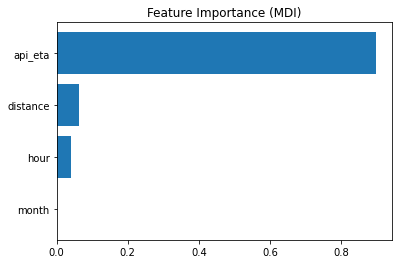

In [ ]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(eta_features)[sorted_idx])
plt.title('Feature Importance (MDI)')
plt.show()

HistGradientBoostingRegressor를 쓰면 데이터의 갯수가 많을때 연산 속도가 훨씬 빠르다.

이 모델은 input feature로 category feature도 사용가능합니다. 그러기 위해서는 우선 아래 예시와 같이 category feature를 ordinal encoding을 통해서 0부터 (category갯수-1)까지의 숫자 중 하나로 변환해줘야 합니다. 

ordinal encoding을 한 후, HistGradientBoostingRegressor을 정의할 때 input parameter인 categorical_feature를 통해 몇 번째 feature가 categorical feature인지 알려줘야 합니다. 예를 들어 세 번째(index는 2) feature가 categorical feature라면 categorical_features=[2]가 됩니다.


categorical feature를 쓰지 않더라도 이 HistGradientBoostingRegressor를 쓰면 데이터의 갯수가 많을때 연산 속도가 훨씬 빠르니 GradientBoostingRegressor 대신 사용을 추천드립니다.

#HistGradientBoostingRegressor

In [43]:
import sklearn.preprocessing

In [44]:
tada_eta = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/data/tada_eta.xlsx')
# Ordianl Encoding
enc = sklearn.preprocessing.OrdinalEncoder(dtype=np.int32)
ordinal = enc.fit_transform(np.asarray(tada_eta['pickup_gu']).reshape(-1,1))
tada_eta['pickup_gu'] = ordinal[:,0] # 0번째 인덱스 칼럼
tada_eta['distance'] = ((tada_eta['pickup_lat']-tada_eta['driver_lat'])**2 + (tada_eta['pickup_lng']-tada_eta['driver_lng'])**2)*100000
tada_eta = tada_eta.drop(['id', 'created_at_kst', 'driver_id', 'pickup_lng', 'pickup_lat', 'driver_lng','driver_lat'],1)

In [45]:
tada_eta = tada_eta.sample(frac=1, random_state=0).reset_index(drop=True)
tada_eta.head()

,ATA,api_eta,month,pickup_gu,hour,distance
0,6.13,8.32,12,12,22,44.521977
1,5.37,3.05,12,17,11,3.989066
2,6.27,5.00,7,22,19,4.814699
3,10.52,8.47,12,20,21,77.341173
4,12.45,6.65,7,0,12,14.888851


In [46]:
tada_eta.head()

,ATA,api_eta,month,pickup_gu,hour,distance
0,6.13,8.32,12,12,22,44.521977
1,5.37,3.05,12,17,11,3.989066
2,6.27,5.00,7,22,19,4.814699
3,10.52,8.47,12,20,21,77.341173
4,12.45,6.65,7,0,12,14.888851


## 구는 카테고리 피쳐니까 잠깐 빼고,

In [47]:
pickup_gu_m=tada_eta['pickup_gu']
tada_eta=tada_eta.drop('pickup_gu',1)

In [48]:
tada_eta.head(1)

,ATA,api_eta,month,hour,distance
0,6.13,8.32,12,22,44.521977


## 데이터 셋 나누기

## PCA & 정규화는 생략. 오히려 성능 떨어짐

In [49]:
train = tada_eta[:12000]
test = tada_eta[12000:]


x_train = np.asarray(train.drop('ATA',1))
y_train = np.asarray(train['ATA'])
x_test = np.asarray(test.drop('ATA',1))
y_test = np.asarray(test['ATA'])
eta_features = [x for i,x in enumerate(tada_eta.columns) if i!=0]

# PCA는 생략한다.

# # Principal Components Analysis (PCA)
# # Using PCA to find the first two principal components of the breast cancer dataset
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.datasets import load_breast_cancer

# # Before applying PCA, each feature should be centered (zero mean) and with unit variance
# # PCA를 하기전에는 정규화를 해야한다. 그렇지 않으면 성능이 좋지 않을 수 있다..!

# X_normalized = StandardScaler().fit(x_train).transform(x_train)  
# pca = PCA(n_components = 2).fit(X_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
# X_pca = pca.transform(X_normalized) # transform은 해줘야 한다.

# # print(train.shape, X_pca.shape)


# x_normalized = StandardScaler().fit(x_test).transform(x_test)  
# pca = PCA(n_components = 2).fit(x_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
# x_pca = pca.transform(x_normalized) # transform은 해줘야 한다.

# print(x_train.shape, X_pca.shape,x_test.shape,x_pca.shape)

## grid search & early_stopping =False, random_state=0 추가

In [50]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# 이제 앙상블에서 정상적으로 가져올 수 있습니다.
from sklearn.metrics import mean_absolute_error

In [52]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# Hyperparameter 조합 정의
param_grid = {'max_iter': [100, 200, 300],
  'max_depth': [2, 3, 4, 5],
   'min_samples_leaf': [1, 20, 100],
  'learning_rate': [0.01, 0.02, 0.05],
  'early_stopping':['False'],
  'random_state':[0]
  # 'categorical_features':[5]
  }
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.HistGradientBoostingRegressor(),
                   param_grid=param_grid, 
                   cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
reg = ensemble.HistGradientBoostingRegressor(**grid_search.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
{'early_stopping': 'False', 'learning_rate': 0.05, 'max_depth': 3, 'max_iter': 100, 'min_samples_leaf': 1, 'random_state': 0}


In [61]:
params = {'max_iter': 100, # 트리의 개수
          'max_depth': 3,
           'min_samples_leaf': 1,
          'learning_rate': 0.06,
          'early_stopping':'False',
          'random_state':0
           } # 'squared_error'와 같음


hist = ensemble.HistGradientBoostingRegressor(**params)
hist.fit(x_train, y_train)

mse = mean_squared_error(y_test, hist.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, hist.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 8.3750
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0830
The initial error of API ETA on test set: 2.7047


## PredefinedSplit, 파라미터 늘리기

In [62]:
# 파라미터 값 좀 더 확장
param_grid = {'max_iter': [100, 200, 300, 400],
  'max_depth': [1,2, 3, 4,5],
   'min_samples_leaf': [1, 20, 50, 100],
  'learning_rate': [0.01, 0.02, 0.05],
  'early_stopping':['False'],
  'random_state':[0]
  #  'categorical_features':[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
   } 

In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# from sklearn.ensemble import HistGradientBoostingRegressor


# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((x_train,x_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(x_train)+[0]*len(x_test))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.HistGradientBoostingRegressor(), 
                   param_grid=param_grid,
                   cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

Fitting 1 folds for each of 240 candidates, totalling 240 fits
{'early_stopping': 'False', 'learning_rate': 0.02, 'max_depth': 5, 'max_iter': 200, 'min_samples_leaf': 100, 'random_state': 0}


--

In [68]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


params = {'max_iter': 200, # 트리의 개수
          'max_depth': 5,
           'min_samples_leaf': 100,
          'learning_rate': 0.02,
          'early_stopping':'False',
          'random_state':0
         } # 'squared_error'와 같음

hist = ensemble.HistGradientBoostingRegressor()
hist.set_params(**params)
         
hist.fit(x_train, y_train)

mse = mean_squared_error(y_test, hist.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_test[:,0]) ))

mae = mean_absolute_error(y_test, hist.predict(x_test))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_test[:,0]) ))

The mean squared error (MSE) on test set: 8.2643
The initial error of API ETA on test set: 13.7135
The mean absolute error (MAE) on test set: 2.0688
The initial error of API ETA on test set: 2.7047


성능 : 8.2643

------------

# 카테고리 피쳐 구 추가, PCA 적용

In [ ]:
# tada_eta['pickup_gu']=pickup_gu_m
# tada_eta.head()

In [ ]:
# tada_eta.drop('pickup_gu',axis=1,inplace=True)

In [69]:
tada_eta.head()

,ATA,api_eta,month,hour,distance
0,6.13,8.32,12,22,44.521977
1,5.37,3.05,12,11,3.989066
2,6.27,5.00,7,19,4.814699
3,10.52,8.47,12,21,77.341173
4,12.45,6.65,7,12,14.888851


In [70]:
# Principal Components Analysis (PCA)
# Using PCA to find the first two principal components of the breast cancer dataset
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

# Before applying PCA, each feature should be centered (zero mean) and with unit variance
# PCA를 하기전에는 정규화를 해야한다. 그렇지 않으면 성능이 좋지 않을 수 있다..!

X_normalized = StandardScaler().fit(x_train).transform(x_train)  
pca = PCA(n_components = 2).fit(X_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
X_pca = pca.transform(X_normalized) # transform은 해줘야 한다.

# print(train.shape, X_pca.shape)


x_normalized = StandardScaler().fit(x_test).transform(x_test)  
pca = PCA(n_components = 2).fit(x_normalized) # n_componets =2 는 2차원으로 변환한다는 걸 뜻한다. 
x_pca = pca.transform(x_normalized) # transform은 해줘야 한다.

print(x_train.shape, X_pca.shape,x_test.shape,x_pca.shape)




(12000, 4) (12000, 2) (1916, 4) (1916, 2)


In [71]:
pick_12000,pickup_1916=pickup_gu_m[:12000],pickup_gu_m[12000:]

In [72]:
pick_12=np.asarray(pick_12000).reshape(-1,1)
pick_19=np.asarray(pickup_1916).reshape(-1,1)

In [73]:
pick_19.shape

(1916, 1)

In [74]:
 pick_=np.asarray(pickup_gu_m).reshape(-1,1)

x_pca=np.concatenate((x_pca,pick_19),axis=1)
X_pca=np.concatenate((X_pca,pick_12),axis=1)

In [ ]:
# 파라미터 값 좀 더 확장한 버전으로
param_grid = {'max_iter': [100, 200, 300,400],
  'max_depth': [1,2, 3, 4, ],
   'min_samples_leaf': [1, 20, 50],
  'learning_rate': [0.01, 0.02, 0.05],
  'early_stopping':['False'],
  'categorical_features':[2],
  'random_state':[0]} 



from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
# from sklearn.ensemble import HistGradientBoostingRegressor


# train set과 test set의 input과 output를 각각 이어 붙여서 X,y를 정의 
X = np.concatenate((X_pca,x_pca), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

# 전체 데이터 X에서 training data에 해당하는 index는 -1, test data에 해당하는 index는 0이 되도록, 
# 여기서는 [-1, -1, ... , -1, 0, 0, ... , 0] 같은 형태의 1차원 배열 test fold와 predefined split을 정의
pds = PredefinedSplit(test_fold=[-1]*len(X_pca)+[0]*len(x_pca))
# grid search 모델 정의, 학습 및 model selection
grid_search = GridSearchCV(estimator=ensemble.HistGradientBoostingRegressor(), 
                   param_grid=param_grid,
                   cv=pds, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X, y)
print(grid_search.best_params_)

### PCA를 쓰니 결과가 더 안좋아졌다. PCA 기법은 배제한다.

In [78]:
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


params = {'max_iter': 100, # 트리의 개수
          'max_depth': 4,
           'min_samples_leaf': 20,
          'learning_rate': 0.05,
          'early_stopping':'False'
          ,'categorical_features':2,
          'random_state':0
         } 

hist = ensemble.HistGradientBoostingRegressor()
hist.set_params(**params)
         
hist.fit(X_pca, y_train)

mse = mean_squared_error(y_test, hist.predict(x_pca))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The initial error of API ETA on test set: {:.4f}".format(mean_squared_error(y_test, x_pca[:,0]) ))

mae = mean_absolute_error(y_test, hist.predict(x_pca))
print("The mean absolute error (MAE) on test set: {:.4f}".format(mae))
print("The initial error of API ETA on test set: {:.4f}".format(mean_absolute_error(y_test, x_pca[:,0]) ))

The mean squared error (MSE) on test set: 10.5227
The initial error of API ETA on test set: 94.1883
The mean absolute error (MAE) on test set: 2.4254
The initial error of API ETA on test set: 8.4648


## 최종:
### The mean squared error (MSE) on test set: 8.2643

----------------------------